In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import LambdaCallback
import random
import io
import sys


2024-09-01 17:01:55.910334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 17:01:56.040779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 17:01:56.077607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 17:01:56.328552: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 17:01:57.495353: W tensorflow/compiler/tf2

In [2]:
# URL de la página que contiene el resumen de "Drácula" de Bram Stoker
url = "https://librovoz.com/resumen-de/dracula-bram-stoker/"

# Realizar una solicitud GET a la URL para obtener el contenido de la página
response = requests.get(url)

# Verificar que la solicitud fue exitosa
if response.status_code == 200:
    # Parsear el contenido HTML de la página
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extraer el texto deseado (aquí se asume que el contenido principal está dentro de etiquetas <p>)
    paragraphs = soup.find_all('p')
    text = ' '.join([para.get_text() for para in paragraphs])

    # Convertir el texto a minúsculas para estandarizarlo
    text = text.lower()

    # Imprimir la longitud del texto extraído
    print(f"Corpus length: {len(text)} characters")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")

Corpus length: 17868 characters


In [3]:
print(text)

drácula, considerada la obra de terror más famosa de la literatura universal, fue publicada por bram stoker en 1897. en realidad, stoker no creó la figura del vampiro, sino que la dio a conocer, puesto que mucho antes de la publicación de esta novela ya existían historias sobre vampiros que sirvieron de inspiración para el escritor. la historia comienza con el viaje desde londres a pensilvania del abogado jonathan harker dirigiéndose al castillo de drácula. su misión es llevar unos papeles por la compra de unos terrenos que ha hecho drácula en londres. llega a la ciudad de bistritz, dónde hace una parada. se hospeda en un hotel, allí le entregan una carta comunicándole que tiene reservado un pasaje al día siguiente en la diligencia con dirección a bucovina, allí en un cruce lo recogerá el chofer del conde. pregunta si conocen a drácula, la anciana del hotel le advierte de que corre peligro, que no vaya a su destino y le entrega un rosario para que se lo cuelgue del cuello para proteger

In [4]:
# Crear un diccionario de caracteres únicos y asignar un índice a cada uno
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Configuración de la longitud de las secuencias para entrenar el modelo
sequence_length = 35  # Longitud de las secuencias
step = 3  # Paso para la ventana deslizante

# Dividir el texto en secuencias de longitud fija
sequences = []
next_chars = []

for i in range(0, len(text) - sequence_length, step):
    sequences.append(text[i: i + sequence_length])
    next_chars.append(text[i + sequence_length])

print(f'Total sequences: {len(sequences)}')

Total sequences: 5945


In [5]:
# Convertir las secuencias en índices utilizando el diccionario 'char_indices'
X = np.zeros((len(sequences), sequence_length, len(chars)), dtype=np.bool_)
y = np.zeros((len(sequences), len(chars)), dtype=np.bool_)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
# Crear el modelo secuencial con una capa LSTM y una capa densa con softmax
model = Sequential()
model.add(LSTM(256, input_shape=(sequence_length, len(chars))))
model.add(Dropout(0.5))  # Añadir una capa Dropout para evitar el sobreajuste
model.add(LSTM(128, input_shape=(sequence_length, len(chars))))
model.add(Dropout(0.2))  # Añadir una capa Dropout para evitar el sobreajuste
model.add(Dense(len(chars), activation='softmax'))

# Compilar el modelo con la función de pérdida categorical_crossentropy, el optimizador Adam y la métrica de precisión (accuracy)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1725228147.634565   23544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-01 17:02:28.031456: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/decidle09/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 52)             │         6,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,380 (388.20 KB)

 Trainable params: 99,380 (388.20 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Función para generar texto con diferentes temperaturas
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Inicializar listas para almacenar métricas
loss_history = []
accuracy_history = []
temperature_history = {0.2: [], 0.5: [], 1.0: [], 1.2: []}

# Callback para generar texto y registrar métricas durante el entrenamiento
def on_epoch_end(epoch, logs):
    print(f'\n----- Generating text after Epoch: {epoch}')

    # Guardar la pérdida (loss) y la precisión (accuracy) de la época actual
    loss_history.append(logs['loss'])
    accuracy_history.append(logs['accuracy'])

    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print(f'----- Seed: "{generated_text}"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print(f'----- Temperature: {temperature}')
        sys.stdout.write(generated_text)

        generated_sequence = generated_text

        for i in range(400):  # Generar 400 caracteres
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                if char in char_indices:
                    sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            generated_sequence += next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()

        temperature_history[temperature].append(generated_sequence)
        print()



In [9]:
# Añadir el callback para generación de texto
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# Entrenar el modelo
history = model.fit(X, y,
                    batch_size=128,
                    epochs=20,
                    callbacks=[print_callback])

# Guardar el modelo entrenado
model.save('lstm_text_generation_model.keras')

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1057 - loss: 3.5909
----- Generating text after Epoch: 0
----- Seed: " en 1970 se encontraron todas las a"
----- Temperature: 0.2
 en 1970 se encontraron todas las a    n      l l        ee                                 s         e  e    n                         e    o              e     e    e s  e  a              a        o    ee   a                         a       e                                 e           e                       a e         e   re                 e       e     u     r        r  s e                          e                   e     
----- Temperature: 0.5
         e                   e     oeer  dc er    nude p itei e   n i e a ls d e da  ua na n i aao        ea iun c .  ca r na        eeoaa u  r   o l      auceu e n   l   aa e    ss  elel en  aelu oee o  elraior oar e ne e  reno oeo   e   sde   a eu  lu  l epr  s l   a  .aan o    e   a o   a  ae   noa  r  e  dl  ene niaed    er  ea os   s a eu 

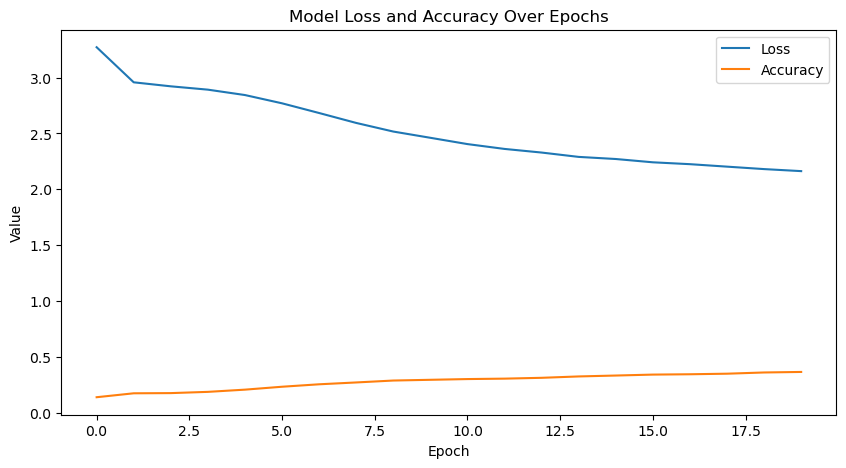


--- Text Generated with Temperature: 0.2 ---
Epoch 1:
 en 1970 se encontraron todas las a    n      l l        ee                                 s         e  e    n                         e    o              e     e    e s  e  a              a        o    ee   a                         a       e                                 e           e                       a e         e   re                 e       e     u     r        r  s e                          e                   e     

Epoch 2:
pueblo costero caracterizado por su       ae   a      a   e e  a e  s   e      o       a    r  e       a        oe         a ea  a      a     a    a  e e     a a        a        a                 e        e    a        e s                a   a                      a      e                  e     o              e     e      e     a               a     a    e        e     e  a              a e a    a   e    a  a e  e     e    e    a 

Epoch 3:
ia y con ellos los sucesos sobrenat   e e  e  e  e   

In [10]:
# Graficar la pérdida y precisión durante el entrenamiento
import matplotlib.pyplot as plt

# Gráfico de la pérdida
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss')
plt.plot(accuracy_history, label='Accuracy')
plt.title('Model Loss and Accuracy Over Epochs')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Comparar ejemplos de texto generado con diferentes temperaturas
for temperature, sequences in temperature_history.items():
    print(f'\n--- Text Generated with Temperature: {temperature} ---')
    for i, sequence in enumerate(sequences):
        print(f'Epoch {i + 1}:\n{sequence}\n')

In [11]:
print(accuracy_history  )

[0.13910849392414093, 0.1742640882730484, 0.1759461760520935, 0.18704794347286224, 0.2068965584039688, 0.23296888172626495, 0.25483599305152893, 0.2713204324245453, 0.28847771883010864, 0.2950378358364105, 0.3015979826450348, 0.30546677112579346, 0.3128679692745209, 0.32514718174934387, 0.3332211971282959, 0.34163162112236023, 0.34465938806533813, 0.34970563650131226, 0.36063918471336365, 0.36534902453422546]


In [12]:
print(loss_history)

[3.2720887660980225, 2.9580039978027344, 2.9220800399780273, 2.892244577407837, 2.844006299972534, 2.7699971199035645, 2.6831650733947754, 2.5943551063537598, 2.5172500610351562, 2.4613401889801025, 2.4049952030181885, 2.3616955280303955, 2.3292338848114014, 2.2903339862823486, 2.27146577835083, 2.2419369220733643, 2.225191593170166, 2.20308256149292, 2.1811647415161133, 2.1629679203033447]


Probar el modelo

In [14]:
from keras.models import load_model
import numpy as np

# 'chars', 'char_indices', y 'indices_char' han sido definidos previamente
# durante el entrenamiento del modelo.

# Cargar el modelo entrenado
model = load_model('lstm_text_generation_model.keras')

# Definir la semilla
seed_text = "dracula esta".lower()

# Definir la longitud de la secuencia utilizada durante el entrenamiento
sequence_length = 35  # Debe coincidir con el tamaño de secuencia utilizado durante el entrenamiento

# Completar la semilla si es más corta que la longitud de secuencia requerida
if len(seed_text) < sequence_length:
    seed_text = seed_text.rjust(sequence_length)

# Función para generar texto usando el modelo cargado
def generate_text(model, seed_text, num_chars_to_generate, temperature=1.0):
    generated_text = seed_text
    for i in range(num_chars_to_generate):
        sampled = np.zeros((1, sequence_length, len(chars)))
        for t, char in enumerate(seed_text):
            if char in char_indices:
                sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        generated_text += next_char
        seed_text = seed_text[1:] + next_char

    return generated_text

# Función para el sampleo
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Generar texto utilizando la semilla dada
generated_text = generate_text(model, seed_text, num_chars_to_generate=400, temperature=0.5)



# Imprimir el texto generado
print("Generated text:")
print(generated_text)


Generated text:
                       dracula esta an en es y pusar da de enlro pon pos enter as de ua ha ala a se vará lo vinas de la la confala an y sun nontrra para ino le corana a sun el contina y  losto pue piantin . mura. en se lu as y hala ten en mibana a su an un dero a la pian. de un cunento an la con es licinco de que con el cuna que enta en er ela an lucol de la la decalia an pora en pera a de do de la an tucenta pa as con en ela a con
